In [1]:
import torch.nn as nn
import torchvision.models as models
import torch
import gensim
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas
import spacy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import transforms
from tqdm.auto import tqdm
import torch.optim as optim 
import torch.nn.functional as F

## GoogleNet + LSTM Model Architecture

In [2]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(f'Generated caption: {title}')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size=300, should_train=False):
        super(EncoderCNN, self).__init__()
        googlenet = models.googlenet(pretrained=True)
        for param in googlenet.parameters():
            param.requires_grad_(False)
        modules = list(googlenet.children())[:-3]
        self.googlenet = nn.Sequential(*modules)
        
    def forward(self, x):
        features = self.googlenet(x)  # batch_size,1024,1,1  
        features = features.permute(0, 2, 3, 1)  # batch_size,1,49,1024
        features = features.view(features.size(0), -1, features.size(-1))  # batch_size,49,1024
        return features
        

In [4]:
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
    def forward(self, features, hidden_state):
        
        u_hs = self.U(features)    #(batch_size,attention_dim)
        w_ah = self.W(hidden_state)  #(batch_size,num_layers,attention_dim) 
        
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1))
        
        attention_scores = self.A(combined_states)          #(batch_size,num_layers,1)
        
        attention_scores = attention_scores.squeeze(2)  #(batch_size,num_layers)
        
        alpha = F.softmax(attention_scores,dim=1) #(batch_size,num_layers)
     
    
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
      
        return alpha,attention_weights
        

In [5]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
      
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
   
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the alpha score
            alphas.append(alpha.cpu().detach().numpy())
            
            #initial lstm input (word & image context)
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [6]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

## Getting the dataset

In [7]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [text.lower() for tok in text.split(' ')]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        for sentence in sentences:
            for word in sentence.lower().split(' ')[:-1]:
             
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1) and word not in self.stoi:
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = sentence.lower().split(' ')[:-1] # Remove fullstops
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]
                    
        

In [8]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir="../input/flickr8kimagescaptions/flickr8k/images", caption_path="../input/flickr8kimagescaptions/flickr8k/captions.txt", freq_threshold=4, transform=None, data_length=10000):
        
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pandas.read_csv(caption_path)
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        self.vocab = Vocabulary(freq_threshold)
        
        self.vocab.build_vocabulary(self.df['caption'].to_list())
    
    def __len__(self):
        
        return len(self.df)
    
    def __getitem__(self, index):
        
        
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = []
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [9]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_value)
        
        return img, targets

In [10]:
transform = transforms.Compose(
        [
            transforms.Resize(226),
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
        ]
    )

In [11]:
def get_loader(root_dir="../input/flickr8kimagescaptions/flickr8k/images", caption_path="../input/flickr8kimagescaptions/flickr8k/captions.txt", transform=transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = 0
    
    loader = DataLoader(dataset=dataset, batch_size=256, num_workers=8, shuffle=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset

In [12]:
loader, dataset = get_loader()

## Lets load a random example.

In [13]:
dataset[0][0].size()

torch.Size([3, 224, 224])

In [14]:
x, y = dataset[0]
x.shape, y.shape

(torch.Size([3, 224, 224]), torch.Size([19]))

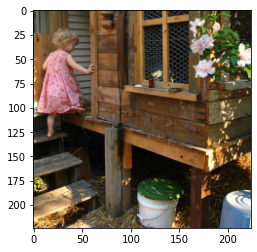

<SOS> a child in a pink dress is climbing up a set of stairs in an <UNK> way <EOS>


In [15]:
import matplotlib.pyplot as plt

show_image(x)

print(' '.join([dataset.vocab.itos[int(w)] for w in y]))

In [16]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

In [17]:
def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

## Training the model

### Hyperparameters

In [18]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = False
train_CNN = False

In [19]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=1024
decoder_dim=512
learning_rate = 3e-4

In [20]:
#init model
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [21]:
# for name, param in model.encoder.inception.named_parameters():
#     if "fc.weight" in name or "fc.bias" in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

Epoch: 0 loss: 4.57290


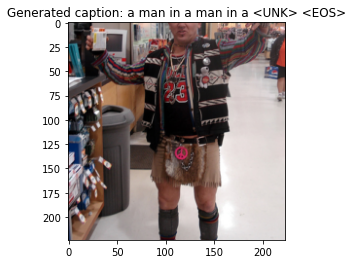

Epoch: 1 loss: 3.81442


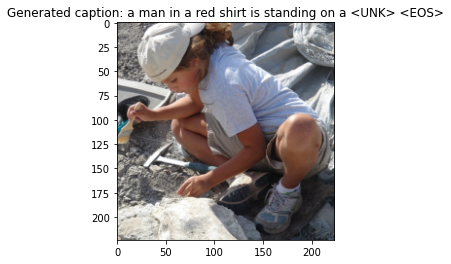

Epoch: 2 loss: 3.58069


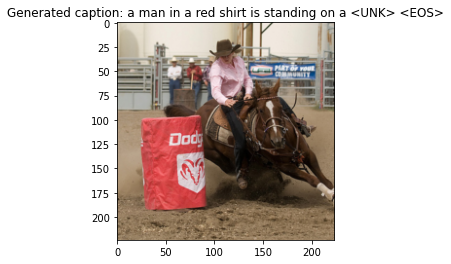

Epoch: 3 loss: 3.37706


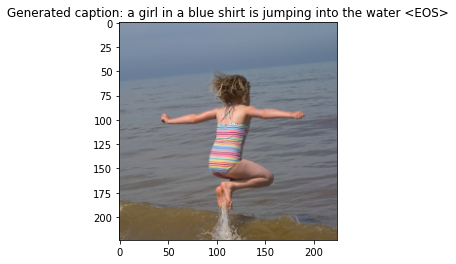

Epoch: 4 loss: 3.12344


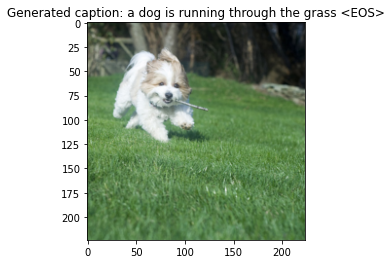

Epoch: 5 loss: 3.19099


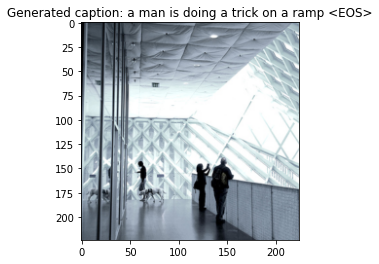

Epoch: 6 loss: 2.94545


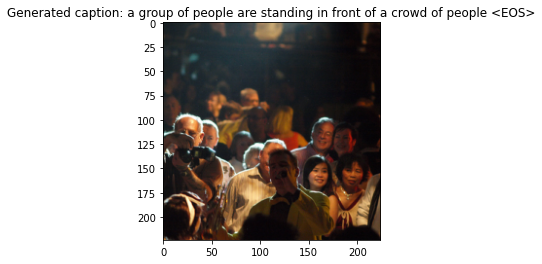

Epoch: 7 loss: 2.91772


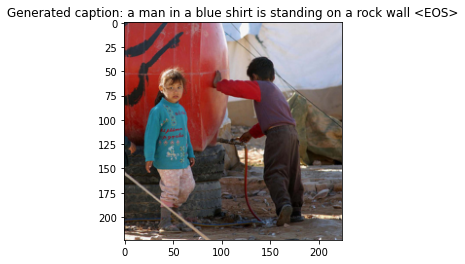

Epoch: 8 loss: 2.98686


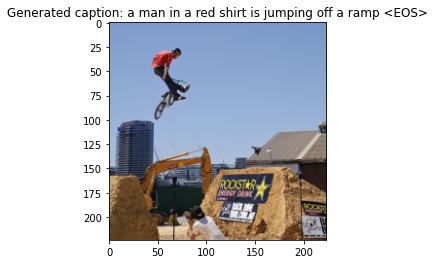

Epoch: 9 loss: 2.86063


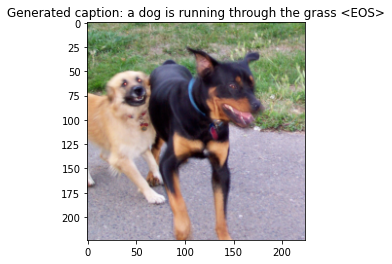

Epoch: 10 loss: 2.80451


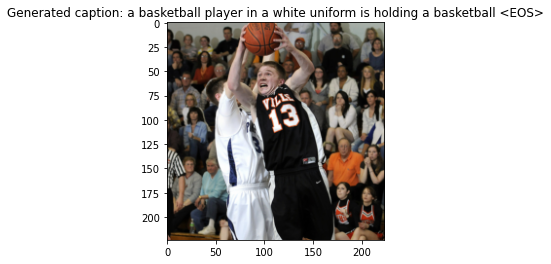

Epoch: 11 loss: 2.73600


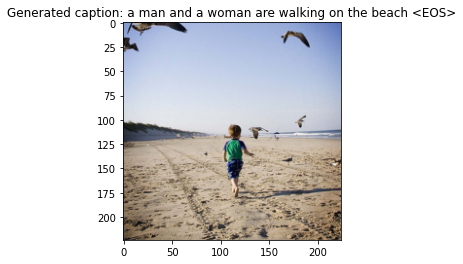

Epoch: 12 loss: 2.53029


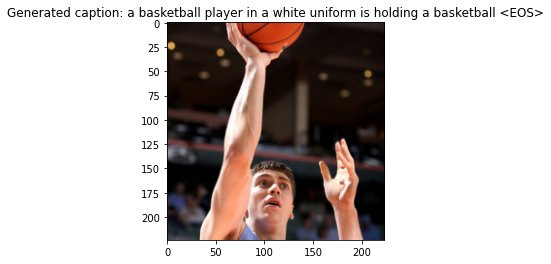

Epoch: 13 loss: 2.65658


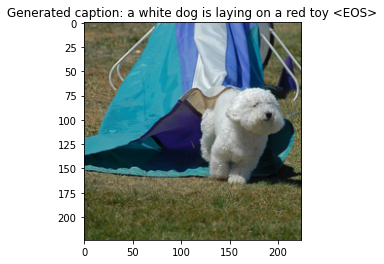

Epoch: 14 loss: 2.57741


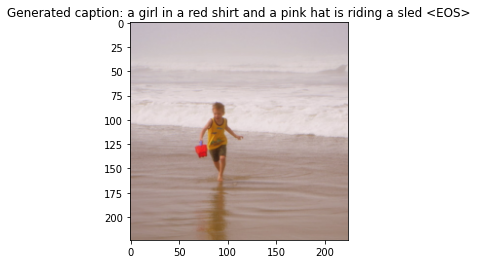

In [22]:
model.train()
num_epochs = 15
print_every = 100

for epoch in range(num_epochs):
    
    for idx,(imgs, captions) in enumerate(iter(loader)):
        
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        # Feed forward
        outputs,attentions = model(imgs, captions)
        
        # Calculate the batch loss
        targets = captions[:,1:]

        optimizer.zero_grad()
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        loss.backward()
        optimizer.step()
        
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
        #generate the caption
            model.eval()
            with torch.no_grad():
                features = model.encoder(imgs[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                
                caption = ' '.join(caps)
                show_image(imgs[0].cpu(),title=caption)
        
        model.train()

- Save the model

In [23]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state_2.pth')

## Comparing the model with original captions

In [24]:
# model = torch.load('../input/attention-model/attention_model_state_2.pth')

In [25]:
captions = pandas.read_csv('../input/flickr8kimagescaptions/flickr8k/captions.txt')

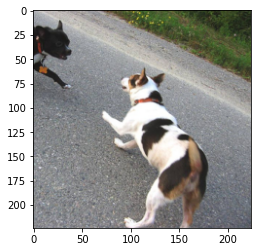

Original Caption: A black dog and a spotted dog are fighting
Predicted Caption: a dog is jumping over a hurdle <EOS>


In [26]:
Path = '../input/flickr8kimagescaptions/flickr8k/images/'
record = captions.iloc[5]
img = Image.open(Path+record['image'])
img = transform(img)
show_image(img)
print(f"Original Caption: {record['caption']}")
model.eval()
features = model.encoder(img.unsqueeze(0).to(device))
caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
caption = ' '.join(caps)
print(f"Predicted Caption: {caption}")


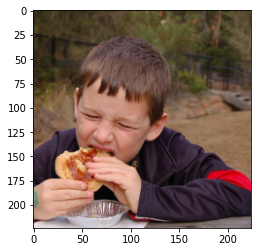

Original Caption: A boy bites hard into a treat while he sits outside .
Predicted Caption: a boy is eating a <UNK> <EOS>


In [27]:
Path = '../input/flickr8kimagescaptions/flickr8k/images/'
record = captions.iloc[150]
img = Image.open(Path+record['image'])
img = transform(img)
show_image(img)
print(f"Original Caption: {record['caption']}")
model.eval()
features = model.encoder(img.unsqueeze(0).to(device))
caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
caption = ' '.join(caps)
print(f"Predicted Caption: {caption}")


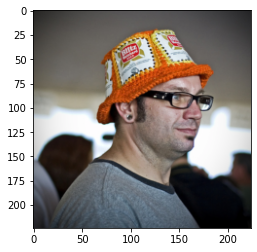

Original Caption: A man in an orange hat starring at something .
Predicted Caption: a man wearing a hat and sunglasses <EOS>


In [28]:
record = captions.iloc[20]
img = Image.open(Path+record['image'])
img = transform(img)
show_image(img)
print(f"Original Caption: {record['caption']}")
model.eval()
features = model.encoder(img.unsqueeze(0).to(device))
caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
caption = ' '.join(caps)
print(f"Predicted Caption: {caption}")

In [32]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()


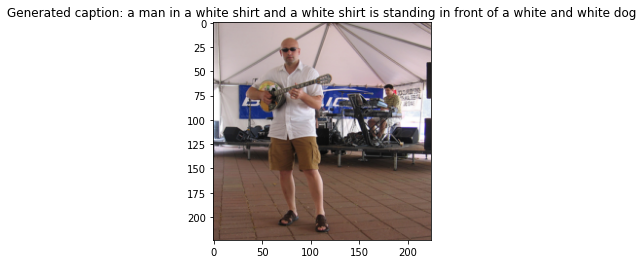

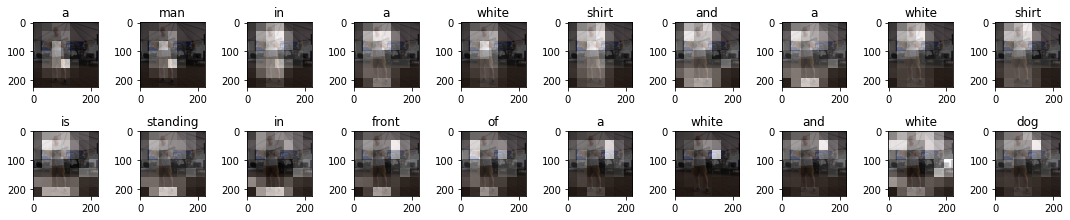

In [35]:
dataiter = iter(loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

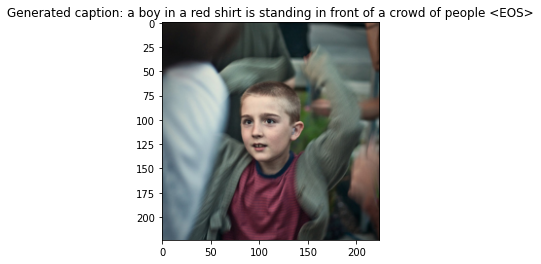

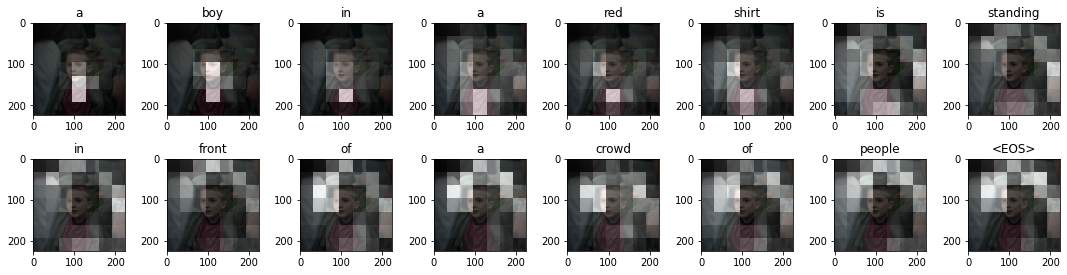

In [34]:
dataiter = iter(loader)
images,label = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
label[]
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)